# Poisson Regression Models
A concise reference is chapter 4 in 
https://data.princeton.edu/wws509/notes/#, but it is worth looking further to get a more complete picture. Out-of-the-box, a Poisson regression assumes the following:

- The error has Poisson distribution, and not a normal distribution as in OLS
- The data is strictly positive.
- The data is skewed.
- The data has discrete distribution (but can be generalized to continuous non-negative)
- Given a log linear model: The dependent variable $(Y)$ is not a linear function of the coefficients. Rather, $ln(Y)$ is a linear function of the coefficients.
- The Poisson distribution does not have separate parameters for the mean and the variance, specifically $\mu = \sigma$. That implies that the distribution of the data is heteroskedastic, where higher counts also fluctuate more widely.

Poisson regression models are hence a natural choice for count data. For example, the number of V2 rocket strikes in different areas of London, the number of children a woman has, etc. The underlying assumption is that counts correspond to independent events, and the probability of two simultaneous events is negligible. 


Specifically, the likelihood of observing a value $y$ is assumed to follow a Poisson distribution:

\begin{equation}
p(y|\mu) = \frac{e^{-\mu} \mu^{y}}{y!}
\end{equation}

Where the only parameter, $\mu$, is both the mean and the variance of the Poisson distribution. The model acquires additional structure when $\mu$ is assumed to be a function of some explanatory variables, $x$, i.e. $\mu = f(x)$. The canonical Poisson regression uses a log-linear relationship between the coefficients and the mean, i.e. $\mu = e^{\mathbf{\beta \cdot x}}$. The result is a generalized linear model with Poisson error and link log.


## Analogy to Least Squares Regression
To anchor intuition in familiar territory, consider least squares regression with a log-linear relationship between endogenous and exogenous variables (that is, the model assumes $log(y)=a + \mathbf{bx}$ that is beset with Gaussian noise). The familiar form for the model is:

\begin{equation}
\begin{array}{rl}
y &= a\exp{\mathbf{b \cdot x}} + \epsilon \\
&= \exp\mathbf{\beta \cdot x} + \epsilon
\end{array}
\end{equation}

Where the constant $a$ was absorbed into the coefficient vector $\mathbf{\beta}$ in the second line, and $\mathbf{x} \rightarrow [1,\mathbf{x}]$. $\epsilon$ is an error term that is assumed to have normal distribution with zero mean, i.e. $\epsilon \sim \mathscr{N}(0,\sigma)$. It's a bit unnatural, but this can be rewritten, absorbing the parameters into the random term:

\begin{equation}
y = 0 + \epsilon'
\end{equation}

With $\epsilon' \sim \mathscr{N}(\mu = \exp{\mathbf{\beta \cdot x}},\sigma)$. Now what if the fluctuations aren't normally distributed about the mean, but they are Poisson distributed about the mean? In that case, $\epsilon' \sim \mathrm{Poisson}(\mu = \exp{\mathbf{\beta \cdot x}})$. 

## Standard Implementation

A model where a linear relationship of the mean of the count to the exogenous variable is justified, and the noise has Poisson distribution. 

The identity between the mean and the variance can be seen in the residuals, which have variance $\sigma = \mu(x)$, and can therefore be rescaled to have constant variance by dividing them by $\sqrt{\mu(x)}$.

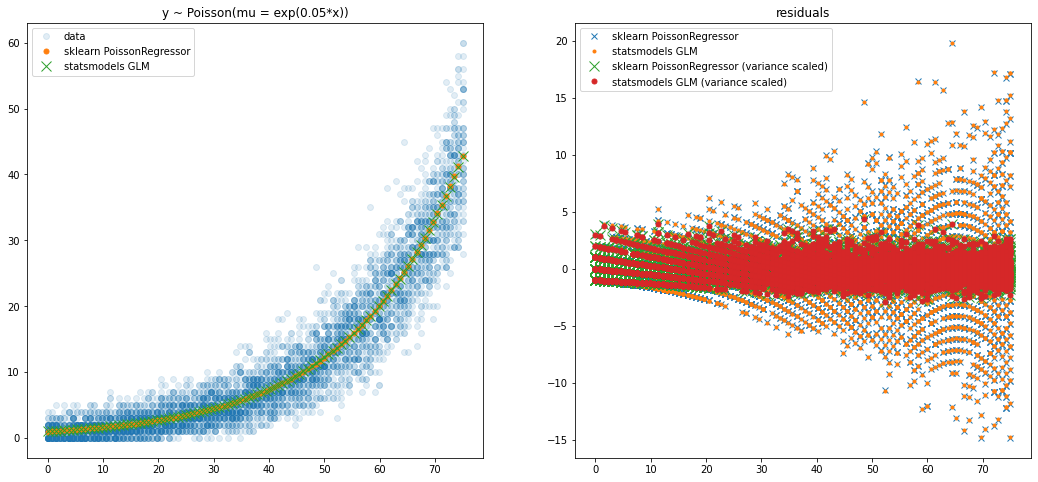

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.linear_model import PoissonRegressor


"""
Generate Data; Linear Case
"""
beta_true = 0.05

def get_samples(x,n_samples):
    mu = np.exp(beta_true*x)
    return np.random.poisson(lam=mu,size=n_samples)#np.random.randint(low=0,high=n_samples,size=1))

xv = np.linspace(0,75,100)
data = []
for x in xv: 
    data += [[x,y] for y in get_samples(x,50)]
data = np.array(data)


"""
Poisson Regressor
"""
reg1 = PoissonRegressor().fit(data[:,0].reshape(-1,1),data[:,1])
reg2 = sm.GLM(exog=data[:,0],endog=data[:,1],family=sm.families.Poisson()).fit()



fig = plt.figure(figsize=(18,8))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax1.plot(data[:,0],data[:,1],alpha=0.125,marker='o',linestyle='')
ax1.plot(xv,reg1.predict(xv.reshape(-1,1)),'.',markersize=10)
ax1.plot(xv,reg2.predict(xv.reshape(-1,1)),'x',markersize=10)
ax1.legend(['data','sklearn PoissonRegressor','statsmodels GLM'])
ax1.set_title('y ~ Poisson(mu = exp(0.05*x))')


res1 = data[:,1]-reg1.predict(data[:,0].reshape(-1,1))
res2 = data[:,1]-reg2.predict(data[:,0].reshape(-1,1))
res1sc = res1/np.sqrt(reg1.predict(data[:,0].reshape(-1,1)))
res2sc = res2/np.sqrt(reg2.predict(data[:,0].reshape(-1,1))) 
ax2.plot(data[:,0],res1,'x')
ax2.plot(data[:,0],res2,'.')
ax2.plot(data[:,0],res1sc,'x',markersize=10)
ax2.plot(data[:,0],res2sc,'.',markersize=10)
ax2.legend(['sklearn PoissonRegressor','statsmodels GLM','sklearn PoissonRegressor (variance scaled)','statsmodels GLM (variance scaled)'])
ax2.set_title('residuals')

plt.savefig('img/poissonmodels01.png')